# Project 4: Predict West Nile Virus
### Section 4. EDA

## Problem Statement

1. As an employee of Disease And Treatment Agency, division of Societal Cures In Epidemiology and New Creative Engineering (DATA-SCIENCE), we are tasked to better understand the mosquito population and advise on appropriate interventions which are beneficial and cost-effective for the city.


2. Through this project, we hope to:
- Identify features which are most important to predict presence of West Nile Virus (which can be done by ranking the coefficients of each feature in a logistic regression model)
- Predict the probability of West Nile Virus by location to provide decision makers an effective plan to deploy pesticides throughout the city, which consequently can help to reduce cost.

## Import Libraries

In [33]:
#!pip install shapely
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely import geometry
from shapely.geometry import Point, Polygon
import geopandas as gpd
from datetime import timedelta
import math

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

## Load Data

In [34]:
# Load datasets
df = pd.read_csv('../data/combined.csv', index_col='Unnamed: 0')

In [35]:
# drop duplicated columns for year, month, week and day of week
df.drop(['year_y', 'month_y', 'week_y', 'dayofweek_y'], axis=1, inplace=True)

In [36]:
# rename unduplicated columns for year, month, week and day of week
df.rename(
    columns={
        "year_x": "year", 
        "month_x": "month",
        "week_x": "week",
        "dayofweek_x": "dayofweek",
    },
    inplace=True
)

As wnvpresent does not increase linearly with year, month, week and day of week (e.g. wnvpresent increased from W32, peaked at week 34 and decreased thereafter), it may be more meaningful to dummify these features if we were to use logistic regression

In [37]:
# Convert year, month, week and day of week to str type to be dummified later on
df['year'] = df['year'].map(str)
df['month'] = df['month'].map(str)
df['week'] = df['week'].map(str)
df['dayofweek'] = df['dayofweek'].map(str)

In [38]:
# Split into train and test (kaggle) data 
train = df[df['dataset']=='train']
test = df[df['dataset']=='test']
print(train.shape)
print(test.shape)

(8304, 35)
(43035, 35)


In [39]:
train.head()

,dataset,date,species,trap,latitude,longitude,wnvpresent,year,month,week,...,sunrise,sunset,codesum,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,is_spray
0,train,2007-05-29,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,0.0,2007,5,22,...,421,1917,BR HZ,0.0,29.39,30.11,5.8,18,6.5,0.0
1,train,2007-05-29,CULEX RESTUANS,T048,41.867108,-87.654224,0.0,2007,5,22,...,421,1917,BR HZ,0.0,29.39,30.11,5.8,18,6.5,0.0
2,train,2007-05-29,CULEX RESTUANS,T091,41.862292,-87.648860,0.0,2007,5,22,...,421,1917,BR HZ,0.0,29.39,30.11,5.8,18,6.5,0.0
3,train,2007-05-29,CULEX RESTUANS,T049,41.896282,-87.655232,0.0,2007,5,22,...,421,1917,BR HZ,0.0,29.39,30.11,5.8,18,6.5,0.0
4,train,2007-05-29,CULEX RESTUANS,T153,41.907645,-87.760886,0.0,2007,5,22,...,421,1917,BR HZ,0.0,29.39,30.11,5.8,18,6.5,0.0


In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8304 entries, 0 to 8303
Data columns (total 35 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   dataset       8304 non-null   object 
 1   date          8304 non-null   object 
 2   species       8304 non-null   object 
 3   trap          8304 non-null   object 
 4   latitude      8304 non-null   float64
 5   longitude     8304 non-null   float64
 6   wnvpresent    8304 non-null   float64
 7   year          8304 non-null   object 
 8   month         8304 non-null   object 
 9   week          8304 non-null   object 
 10  dayofweek     8304 non-null   object 
 11  nummosquitos  8304 non-null   float64
 12  dist_s1       8304 non-null   float64
 13  dist_s2       8304 non-null   float64
 14  nearest_stat  8304 non-null   int64  
 15  level_0       8304 non-null   int64  
 16  station       8304 non-null   int64  
 17  tmax          8304 non-null   int64  
 18  tmin          8304 non-null 

In [41]:
train.columns

Index(['dataset', 'date', 'species', 'trap', 'latitude', 'longitude',
       'wnvpresent', 'year', 'month', 'week', 'dayofweek', 'nummosquitos',
       'dist_s1', 'dist_s2', 'nearest_stat', 'level_0', 'station', 'tmax',
       'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb', 'heat', 'cool',
       'sunrise', 'sunset', 'codesum', 'preciptotal', 'stnpressure',
       'sealevel', 'resultspeed', 'resultdir', 'avgspeed', 'is_spray'],
      dtype='object')

## EDA

### Numeric Features

In [42]:
# Numeric variables
numeric_features = ['latitude', 'longitude',
       'nummosquitos',
       'tmax', 'tmin', 'tavg',
       'depart', 'dewpoint', 'wetbulb', 'heat', 'cool', 'sunrise', 'sunset',
       'preciptotal', 'stnpressure', 'sealevel',
       'resultspeed', 'resultdir', 'avgspeed', 'is_spray'
]

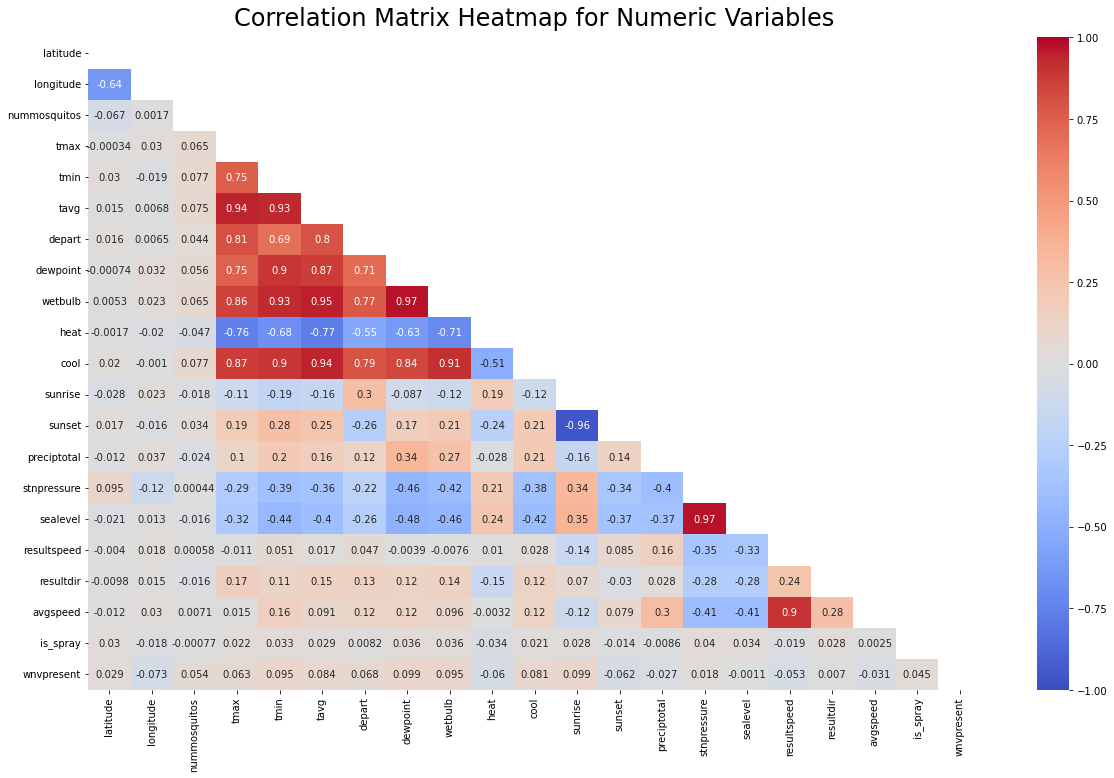

In [43]:
# take a look at the correlation of the numeric features with wnv and collinearity
plt.figure(figsize=(20,12))
mask = np.triu(np.ones_like(train[numeric_features + ['wnvpresent']].corr(), dtype=bool))
corr_matrix = sns.heatmap(train[numeric_features + ['wnvpresent']].corr(), mask=mask, annot=True, vmin=-1, vmax=1, cmap='coolwarm')
corr_matrix.set_title('Correlation Matrix Heatmap for Numeric Variables', fontdict={'fontsize':24}, pad=12);

- Based on correlation matrix and distribution, some features have severe multicollinearity (i.e. correlation >0.8) and have distributions which look similar, so they should not be concurrently added in the model. We will drop one of these features:
    - avgspeed and resultspeed (drop resultspeed): average wind speed and resultant wind speed
    - stnpressure and sealevel (drop sealevel): average station pressure and average sea level pressure
    -  sunrise and sunset (drop sunset): timing of sunrise and sunset
    - cool, wetbulb and dewpoint (drop wetbulb and dewpoint): cooling (season begins with Jan), wet-bulb temperature (the lowest temperature that can be reached under current ambient conditions by the evaporation of water only) and dewpoint (temperature to which air needs to be cooled to in order to achieve a relative humidity of 100%) as these are all measures related to lowering temperature
    - tavg, cool, wetbulb, dewpoint, depart (drop cool and depart): cooling (season begins with Jan) and depart (average temperatures above or below the 30-year normal) can be dropped as well as average temperature in Degrees Fahrenheit would account for these measurements
    - tavg, tmax and tmin (drop tmin and tmax): min and max temperature in Degrees Fahrenheit can be dropped as both are accounted for in the average temperature in Degrees Fahrenheit

In [44]:
# Filter out numeric features with high multicollinearity (i.e. correlation >0.7) - to be used in model
numeric_features = ['latitude', 'longitude',
       'nummosquitos',
       'tavg',
       'preciptotal', 'stnpressure',
       'resultdir', 'avgspeed', 'is_spray'
]

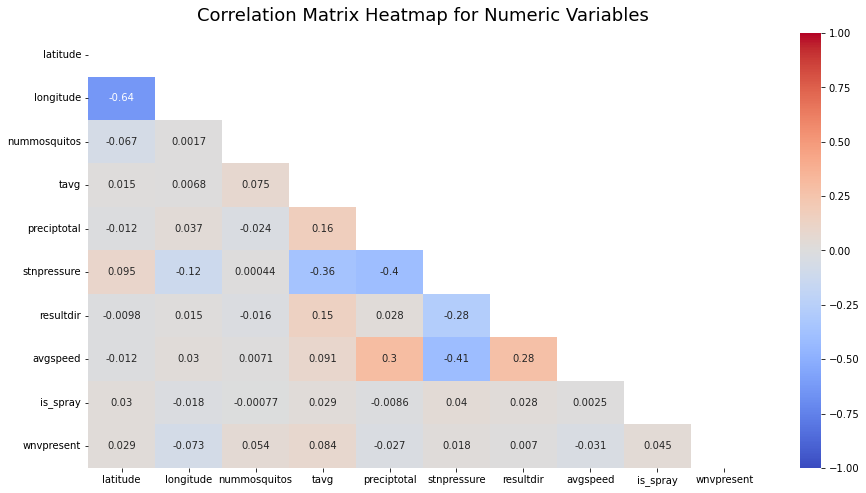

In [45]:
# take a look at the correlation of the filtered numeric features with wnv and collinearity
plt.figure(figsize=(15,8))
mask = np.triu(np.ones_like(train[numeric_features + ['wnvpresent']].corr(), dtype=bool))
corr_matrix = sns.heatmap(train[numeric_features + ['wnvpresent']].corr(), mask=mask, annot=True, vmin=-1, vmax=1, cmap='coolwarm')
corr_matrix.set_title('Correlation Matrix Heatmap for Numeric Variables', fontdict={'fontsize':18}, pad=12);

- wnvpresent is not strongly correlated with location, in terms of longitude and latitude, time of year and weather
- Amongst all numeric features, wnvpresent is most correlated with tavg, followed by longitude, heat, number of mosquitoes and whether spray is provided

In [46]:
# create data frame to store average weather features by year and week
wnv_by_year_week = pd.DataFrame(train.groupby(['year','week'])
                                 .mean()['wnvpresent']).sort_values(by=['week']).reset_index().dropna()
tavg_by_year_week = pd.DataFrame(train.groupby(['year','week'])
                                 .mean()['tavg']).sort_values(by=['week']).reset_index().dropna()
precip_by_year_week = pd.DataFrame(train.groupby(['year','week'])
                                 .mean()['preciptotal']).sort_values(by=['week']).reset_index().dropna()
stnpressure_by_year_week = pd.DataFrame(train.groupby(['year','week'])
                                 .mean()['stnpressure']).sort_values(by=['week']).reset_index().dropna()

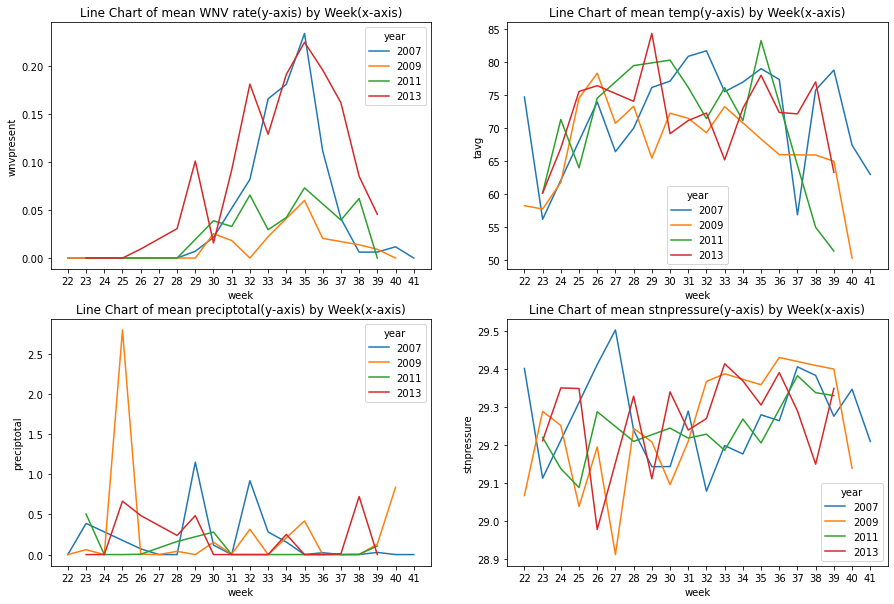

In [47]:
# plot line chart to see change in average weather features across year and week
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
sns.lineplot(data=wnv_by_year_week, x='week', y='wnvpresent',hue='year') \
                .set(title= 'Line Chart of mean WNV rate(y-axis) by Week(x-axis)')

plt.subplot(2, 2, 2)
sns.lineplot(data=tavg_by_year_week, x='week', y='tavg',hue='year') \
                .set(title= 'Line Chart of mean temp(y-axis) by Week(x-axis)')

plt.subplot(2, 2, 3)
sns.lineplot(data=precip_by_year_week, x='week', y='preciptotal',hue='year') \
                .set(title= 'Line Chart of mean preciptotal(y-axis) by Week(x-axis)')

plt.subplot(2, 2, 4)
sns.lineplot(data=stnpressure_by_year_week, x='week', y='stnpressure',hue='year') \
                .set(title= 'Line Chart of mean stnpressure(y-axis) by Week(x-axis)');

- WNV had highest occurrence in 2007 and 2013
    - In 2007, WNV surged from W32 and peaked in W35
    - In 2013, WNV peaked in W28, 32 and 35
- Average temperature peaked around the same period in W32 and 35 in 2007 and W29, 32 and 35.
- There is about a week lag in the surge in WNV after high total precipitation
    - In 2007, total precipitation peaked in W29 and 32, which coincide with a surge in WNV starting from W29 and W32 respectively, lasting for about 1-2 weeks.
    - Similarly in 2013, total precipatation peaked in W25, 29 and 34, which coincide with a surge in WNV starting from these week lasting for about 1-2 weeks. There was a dip in WNV in W30 due to spraying
- Station pressure is inversely related to total precipitation and so it is WNV is about a week lag after the dip in station pressure
    - In 2007, total precipitation peaked in W29 and 32, which coincide with a dip in station pressure.
    - Similarly in 2013, total precipatation peaked in W25, 29 and 34, which coincide with a dip in station pressure in W26, 29 and 35

### Non-numeric Features

In [48]:
# create a function to create dataframe to hold dummies for specified categorical features and wnv
def dummies_wnv_df(colname):
    dummies_df = train[[colname]]
    dummies_df = pd.get_dummies(dummies_df)
    dummy_plus_wnvpresent = pd.concat(objs = [dummies_df, train[['wnvpresent']]] , axis = 1)
    return dummy_plus_wnvpresent

# crate a function to plot heatmap of correlation
def heatmap_corr(df, colname):
    mask = np.triu(np.ones_like(df.corr(), dtype=bool))
    corr_matrix = sns.heatmap(df.corr(), mask=mask, annot=True, vmin=-1, vmax=1, cmap='coolwarm')
    corr_matrix.set_title(f'Correlation Matrix Heatmap for {colname} and WNV', fontdict={'fontsize':18}, pad=12);

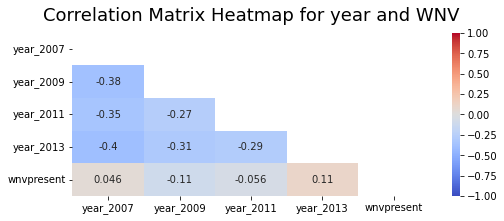

In [49]:
# Look at the correlation of year with wnv
year_wnvpresent = dummies_wnv_df('year')
corr_wnvpresent = year_wnvpresent.corr().sort_values('wnvpresent', ascending=False)

plt.figure(figsize=(8,3))
heatmap_corr(year_wnvpresent, 'year')

- Presence of WNV is not linearly correlated with year (e.g. positively correlated for 2007 and 2013, and negatively correlated for 2009 and 2011), suggesting that it may be more appropriate to use them as dummy variable to account for the non-linear relationship

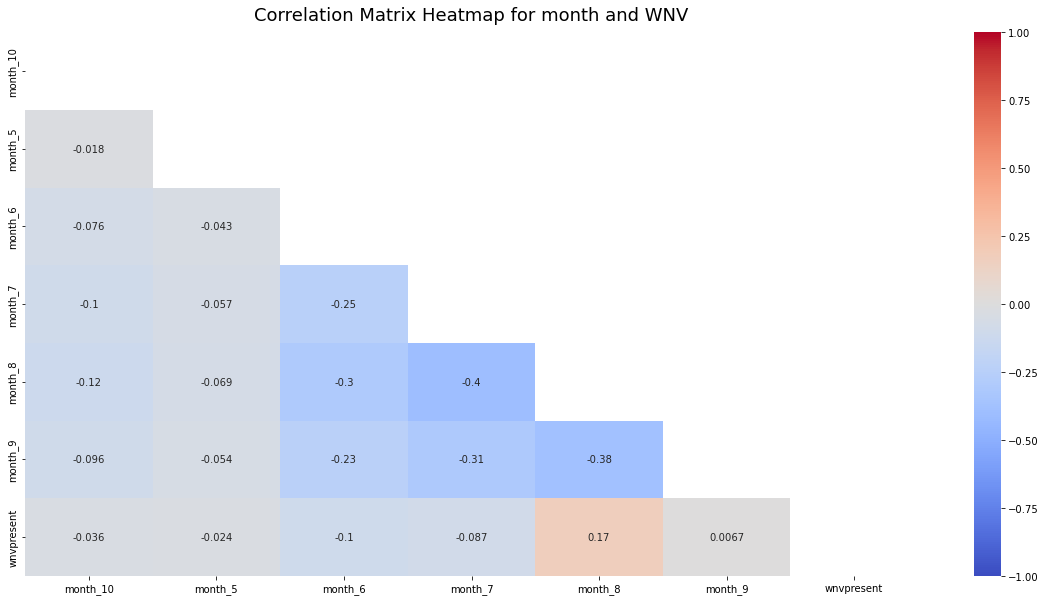

In [50]:
# Look at the correlation of month with wnv
month_wnvpresent = dummies_wnv_df('month')
corr_wnvpresent = month_wnvpresent.corr().sort_values('wnvpresent', ascending=False)

plt.figure(figsize=(20,10))
heatmap_corr(month_wnvpresent, 'month')

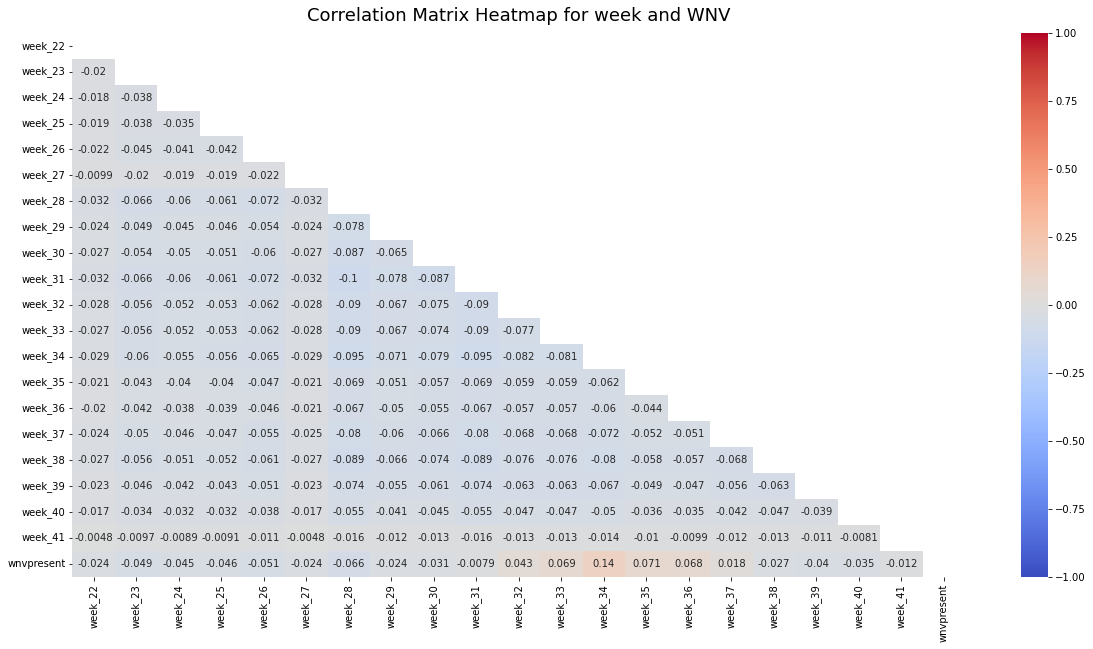

In [51]:
# Look at the correlation of week with wnv
week_wnvpresent = dummies_wnv_df('week')
corr_wnvpresent = week_wnvpresent.corr().sort_values('wnvpresent', ascending=False)

plt.figure(figsize=(20,10))
heatmap_corr(week_wnvpresent, 'week')

- Both month 8 and week34 are more correlated to wnvpresent. As month 8 contains week 31-34, suggest dropping month as week provides higher resolution and more information than month
- Presence of WNV is not linearly correlated with the week (e.g. negatively correlated before W32, positively correlated between W32 and 37, and negatively correlated after W37), suggesting that it may be more appropriate to use them as dummy variable to account for the non-linear relationship

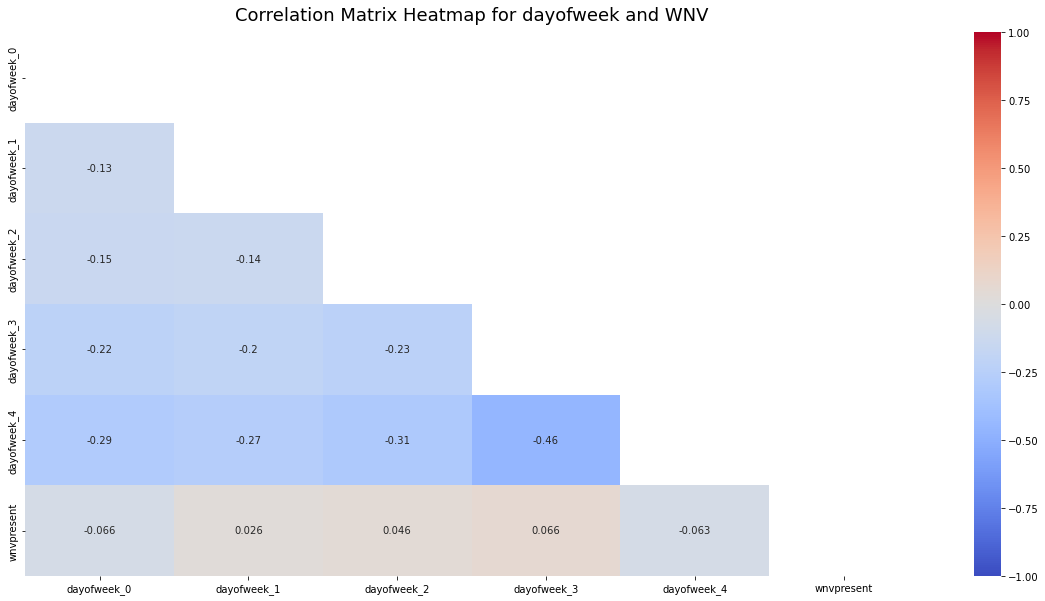

In [52]:
# Look at the correlation of dayofweek with wnv
dayofweek_wnvpresent = dummies_wnv_df('dayofweek')
corr_wnvpresent = dayofweek_wnvpresent.corr().sort_values('wnvpresent', ascending=False)

plt.figure(figsize=(20,10))
heatmap_corr(dayofweek_wnvpresent, 'dayofweek')

Presence of WNV is not linearly correlated with the day of week (e.g. negatively correlated with Monday and Friday but positively correlated with Tue-Thu), suggesting that it may be more appropriate to use them as dummy variable to account for the non-linear relationship

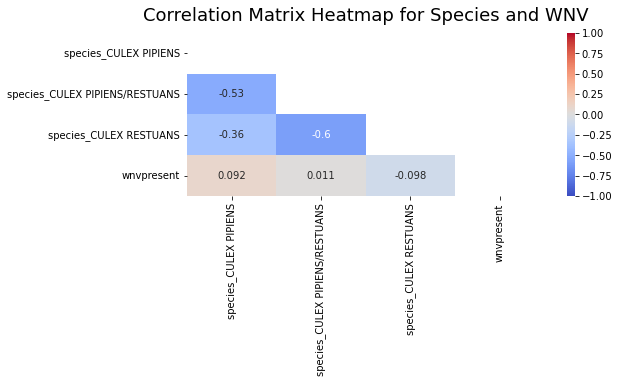

In [53]:
# Look at the correlation of species with wnv
species_wnvpresent = dummies_wnv_df('species')
corr_wnvpresent = species_wnvpresent.corr().sort_values('wnvpresent', ascending=False)

plt.figure(figsize=(8,3))
heatmap_corr(species_wnvpresent, 'Species')

Species of mosquitoes does not seem to have a strong correlation with wnv present but there are generally more CULEX PIPIENS and lesser CULEX RESTUANS

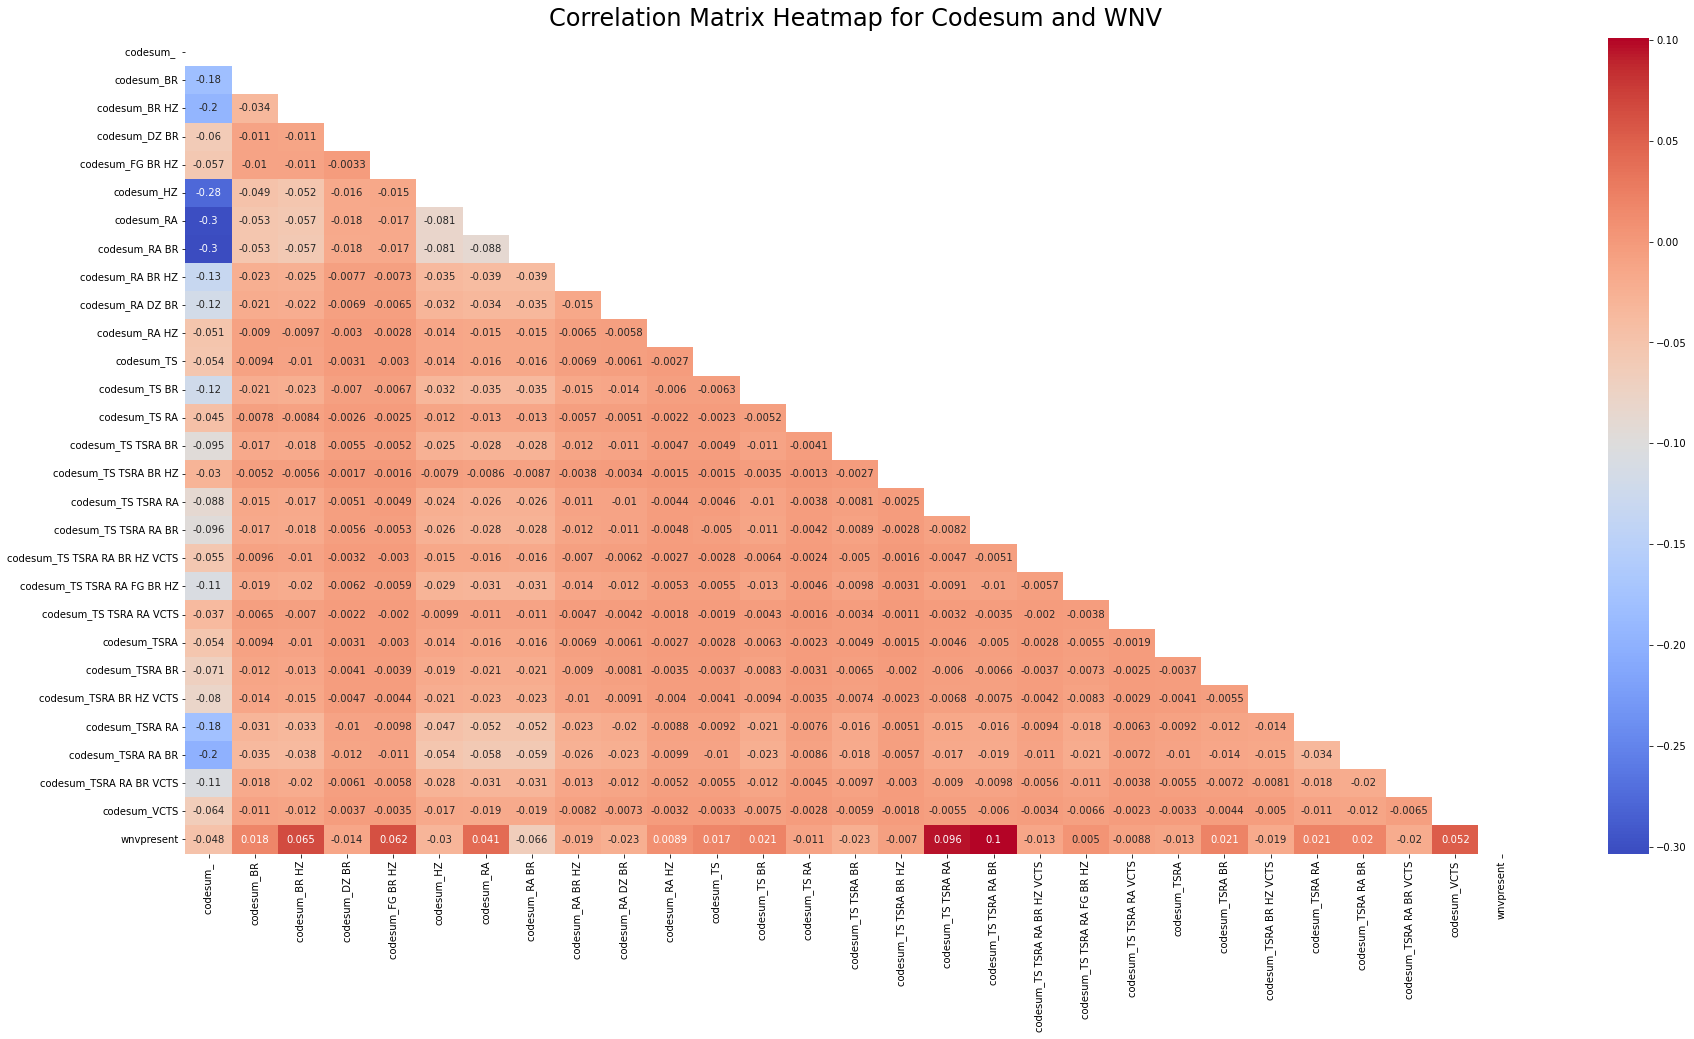

In [54]:
# Look at the correlation of codesum with wnv
codesum_wnvpresent = dummies_wnv_df('codesum')
corr_wnvpresent = codesum_wnvpresent.corr().sort_values('wnvpresent', ascending=False)

plt.figure(figsize=(30,15))
mask = np.triu(np.ones_like(codesum_wnvpresent.corr(), dtype=bool))
corr_matrix = sns.heatmap(codesum_wnvpresent.corr(), mask=mask, annot=True, cmap='coolwarm')
corr_matrix.set_title('Correlation Matrix Heatmap for Codesum and WNV', fontdict={'fontsize':24}, pad=12);

- Presence of WNV is more correlated with:
    - TS TSRA RA BR (Thunderstorm, Thunderstorm & Rain, Rain, Mist) and 
    - TS TSRA RA (Thunderstorm, Thunderstorm & Rain, Rain)

In [55]:
codesum_wnvpresent.corr().sort_values('wnvpresent', ascending=False)['wnvpresent']

wnvpresent                       1.000000
codesum_TS TSRA RA BR            0.100735
codesum_TS TSRA RA               0.095621
codesum_BR HZ                    0.064683
codesum_FG BR HZ                 0.062092
codesum_VCTS                     0.051904
codesum_RA                       0.040965
codesum_TSRA BR                  0.021345
codesum_TS BR                    0.020770
codesum_TSRA RA                  0.020549
codesum_TSRA RA BR               0.019514
codesum_BR                       0.018262
codesum_TS                       0.017425
codesum_RA HZ                    0.008877
codesum_TS TSRA RA FG BR HZ      0.005031
codesum_TS TSRA BR HZ           -0.007010
codesum_TS TSRA RA VCTS         -0.008789
codesum_TS RA                   -0.010603
codesum_TSRA                    -0.012718
codesum_TS TSRA RA BR HZ VCTS   -0.012993
codesum_DZ BR                   -0.014286
codesum_TSRA BR HZ VCTS         -0.018971
codesum_RA BR HZ                -0.018980
codesum_TSRA RA BR VCTS         -0

## Feature Engineering

In [56]:
# Numeric features
numeric_features

['latitude',
 'longitude',
 'nummosquitos',
 'tavg',
 'preciptotal',
 'stnpressure',
 'resultdir',
 'avgspeed',
 'is_spray']

In [57]:
# Categorical features
non_numeric_features = [
    'year',
    'week',
    'dayofweek',
    'species',
    'trap',
    'codesum'
]

We realize that there is a lag of about a week or so between the preciptation fall and the increase in mosquitoes. From desktop research, we found that...

In [58]:
weather = pd.read_csv('../data/processed_weather.csv', index_col='Unnamed: 0')
weather["stnpressure_7"] = weather["stnpressure"].copy().shift(14)
weather["stnpressure_10"] = weather["stnpressure"].copy().shift(20)
weather["preciptotal_7"] = weather["preciptotal"].copy().shift(14)
weather["preciptotal_10"] = weather["preciptotal"].copy().shift(20)

In [59]:
weather_lag = weather[["date","stnpressure_7", "stnpressure_10","preciptotal_7","preciptotal_10","station"]]
weather_lag.tail(15)

,date,stnpressure_7,stnpressure_10,preciptotal_7,preciptotal_10,station
2929,2014-10-17,29.02,29.54,1.05,0.00,2
2930,2014-10-18,29.07,29.44,0.05,0.00,2
2931,2014-10-19,29.02,29.33,0.00,0.00,2
2932,2014-10-20,28.95,29.36,0.01,0.00,2
2933,2014-10-21,29.06,29.28,0.00,0.00,2
2934,2014-10-22,29.34,29.10,0.00,0.72,2
2935,2014-10-23,29.44,29.02,0.00,1.05,2
2936,2014-10-24,29.49,29.07,0.00,0.05,2
2937,2014-10-25,29.53,29.02,0.00,0.00,2
2938,2014-10-26,29.31,28.95,0.01,0.01,2


In [60]:
df_new = pd.merge(df, 
              weather_lag, 
              how='left', 
              left_on= ['date',"nearest_stat"], 
              right_on = ['date',"station"] 
             )



In [61]:
df = df_new.copy()
df.drop(columns=["station_y"], inplace= True)

We want to try and tokenize the code sum data, and split it into their constituent parts, each in separate columns.

In [62]:
df_new = df["codesum"].str.split(" ", expand = True)

# Generate unique list of codes
code_list = []
for cols in df_new.columns:
    code_list.extend(df_new[cols].unique())
code_list=list(set(code_list))

# Remove empty categories
code_list.remove('')
code_list.remove(None)

# Generate columns where codesum contains each code
for i in code_list:
    df[i] = df['codesum'].str.contains(i)

In [63]:
#addition to numeric features

numeric_features = ['latitude', 'longitude',
       'nummosquitos',
       'tmax', 'tmin', 'tavg',
       'depart', 'dewpoint', 'wetbulb', 'heat', 'cool', 'sunrise', 'sunset',
       'preciptotal', 'stnpressure', 'sealevel',
       'resultspeed', 'resultdir', 'avgspeed', 'is_spray', 'stnpressure_7','stnpressure_10', 'preciptotal_7', 'preciptotal_10'
]

In [64]:
#addition to non-numeric features

non_numeric_features = [
    'year',
    'week',
    'dayofweek',
    'species',
    'trap',
    'codesum',
    'DZ', 'BR', 'TSRA',
       'VCTS', 'BCFG', 'FG', 'TS', 'FG+', 'HZ', 'RA'
]

In [65]:
# Create a new dataframe to hold dummies for all categorical features and wnv
dummies_df = df[non_numeric_features]
dummies_df = pd.get_dummies(dummies_df, drop_first=True)
df_dummy_plus_wnvpresent = pd.concat(objs = [dummies_df, df[['wnvpresent', 'dataset']]] , axis = 1)

In [66]:
df_dummy_plus_wnvpresent

,DZ,BR,TSRA,VCTS,BCFG,FG,TS,FG+,HZ,RA,...,codesum_TSRA FG+ BR HZ,codesum_TSRA RA,codesum_TSRA RA BR,codesum_TSRA RA BR HZ,codesum_TSRA RA BR HZ VCTS,codesum_TSRA RA BR VCTS,codesum_TSRA RA VCTS,codesum_VCTS,wnvpresent,dataset
0,False,True,False,False,False,False,False,False,True,False,...,0,0,0,0,0,0,0,0,0.0,train
1,False,True,False,False,False,False,False,False,True,False,...,0,0,0,0,0,0,0,0,0.0,train
2,False,True,False,False,False,False,False,False,True,False,...,0,0,0,0,0,0,0,0,0.0,train
3,False,True,False,False,False,False,False,False,True,False,...,0,0,0,0,0,0,0,0,0.0,train
4,False,True,False,False,False,False,False,False,True,False,...,0,0,0,0,0,0,0,0,0.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51334,False,True,True,False,False,False,True,False,False,True,...,0,0,1,0,0,0,0,0,NaN,test
51335,False,True,True,False,False,False,True,False,False,True,...,0,0,1,0,0,0,0,0,NaN,test
51336,False,True,True,False,False,False,True,False,False,True,...,0,0,1,0,0,0,0,0,NaN,test
51337,False,True,True,False,False,False,True,False,False,True,...,0,0,1,0,0,0,0,0,NaN,test


In [67]:
# Create a new dataframe to hold numeric features, dummies, and wnv
final_df = pd.concat(objs = [df[numeric_features], df_dummy_plus_wnvpresent] , axis = 1)

In [68]:
final_df.columns

Index(['latitude', 'longitude', 'nummosquitos', 'tmax', 'tmin', 'tavg',
       'depart', 'dewpoint', 'wetbulb', 'heat',
       ...
       'codesum_TSRA FG+ BR HZ', 'codesum_TSRA RA', 'codesum_TSRA RA BR',
       'codesum_TSRA RA BR HZ', 'codesum_TSRA RA BR HZ VCTS',
       'codesum_TSRA RA BR VCTS', 'codesum_TSRA RA VCTS', 'codesum_VCTS',
       'wnvpresent', 'dataset'],
      dtype='object', length=252)

### Export CSV

In [69]:
final_df.to_csv('../data/final_df.csv')